# 10. The Jackknife and Bootstrap

* **Jackknife** : a first step toward a computer-based, non-formulatic approach to standard errors 
* **Bootstrap** : toward automating a wide variety of inferential calculations, including standard errors  

## 10.1 The Jackknife estimate of Standard Errors 

### example 1. kidney data correlation between age and tot (kidney function)

In [1]:
library(tidyverse)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [7]:
options("scipen" = 100)

In [2]:
kidney <- read.csv("http://web.stanford.edu/~hastie/CASI_files/DATA/kidney.csv")

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


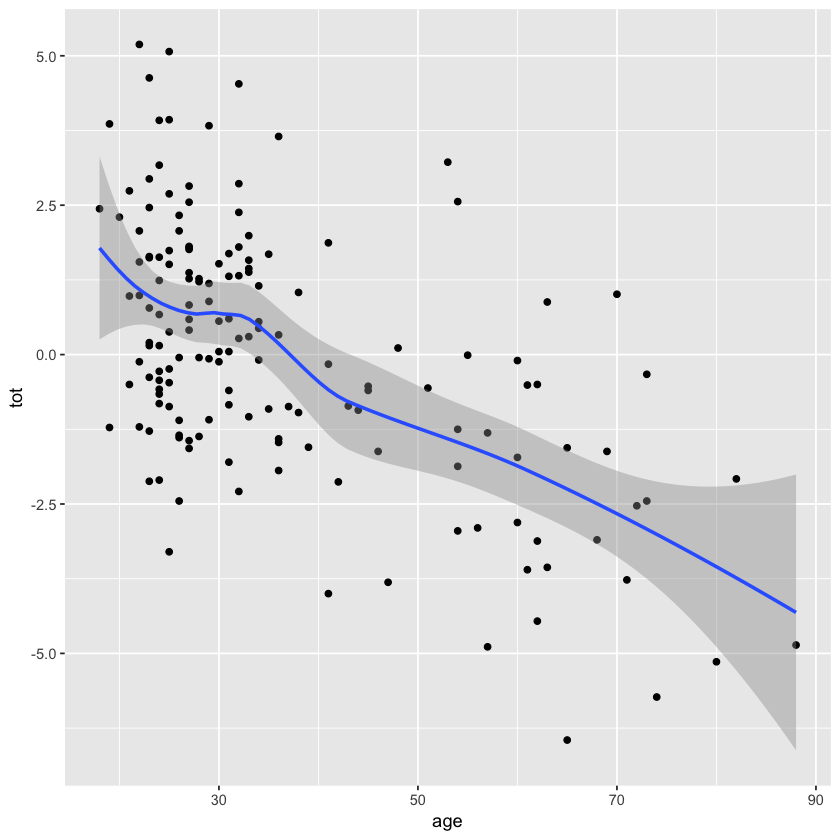

In [3]:
ggplot(kidney, aes(age, tot)) + geom_point() + geom_smooth()

* 왼쪽에 많은 자료들이 모여있고, 변곡점이 있음을 알 수 있다. 

In [4]:
theta.hat = cor(kidney$age, kidney$tot) # 우리의 관심인 theta hat (rho hat)

n = nrow(kidney)
jackknife.all <- NULL # theta(i) hat 
for(i in 1:n) 
    jackknife.all = c(jackknife.all, cor(kidney$age[-i], kidney$tot[-i])) # i번째를 제외한 나머지의 correlation 계산 

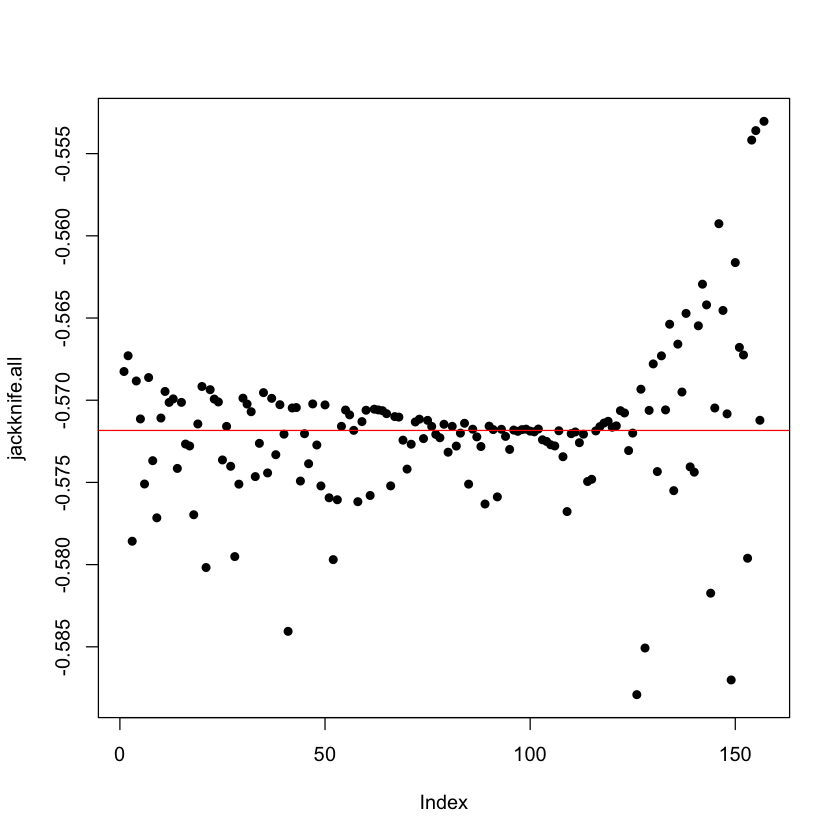

In [5]:
plot(jackknife.all, pch=16)
abline(h=theta.hat, col="red") # 원래의 theta hat 

* data의 개수만큼 그려진 plot 
* 오른쪽의 튀는 점 : 해당 obs는 크게 영향을 미친다 -> 여기의 값들을 빼면 corr 많이 변한다 

In [9]:
se.jack = sqrt((n-1)/n * sum((jackknife.all - mean(jackknife.all))^2)) 
se.jack

[1] 0.05822859

In [10]:
muhk = function(h, k){
    x = kidney$age ; y=kidney$tot
    mean((x-mean(x))^h * (y-mean(y))^k)
}

In [13]:
# taylor series 를 이용해서 대략적으로 계산한 값 
se.taylor = sqrt(theta.hat^2 / (4*n) * 
                (muhk(4,0)/muhk(2,0)^2 + muhk(0,4)/muhk(0,2)^2 +
                 2 * muhk(2,2) / (muhk(2,0) * muhk(0,2)) + 
                 4 * muhk(2,2) / muhk(1,1)^2 - 
                 4 * muhk(3,1) / (muhk(1,1) * muhk(2,0)) - 
                 4 * muhk(1,3) / (muhk(1,1) * muhk(0,2))
                ))

se.taylor # 비슷하게 나온다 

[1] 0.05680082

### example 2. kidney data lownesss model (Fig 10.1) 

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


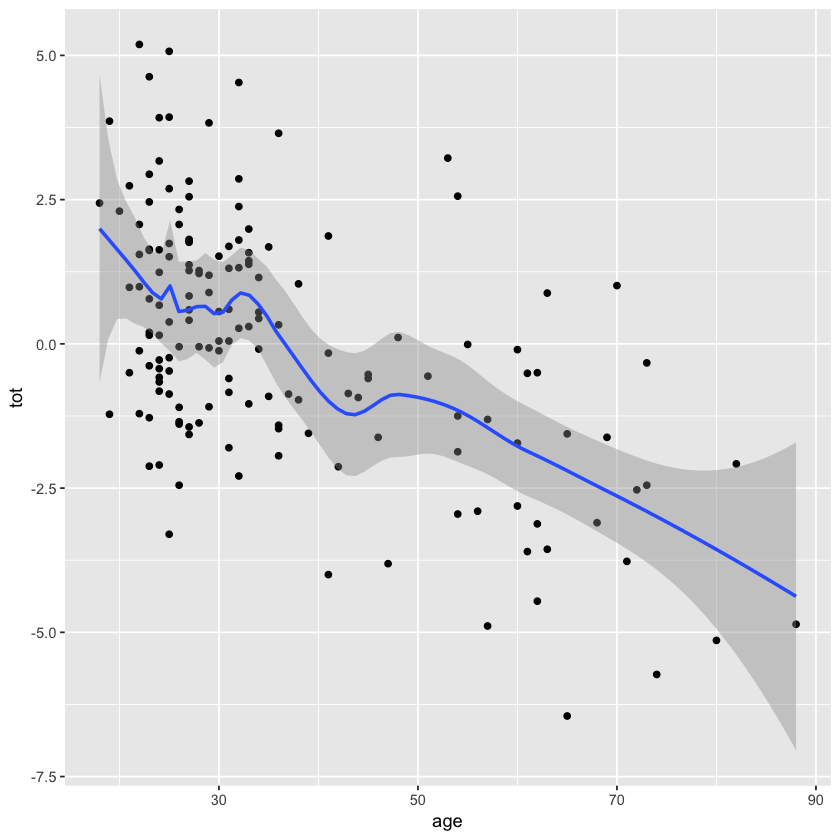

In [15]:
ggplot(kidney, aes(age, tot)) + geom_point() + geom_smooth(span=1/3) 

# span : determine the width of the moving window when smoothing your data
# loess : 비모수적 방법의 회귀분석, 비선형 회귀 분석 방법  

In [16]:
pred.data <- data.frame(age = seq(20, 80, by=5))
theta.hat <- predict(loess(tot~age, data = kidney, span=1/3), newdata = pred.data)
n <- nrow(kidney) # 20, 25, ... , (13개)

jackknife.all <- NULL 
for(i in 1:n) 
    jackknife.all <- rbind(jackknife.all, # theta(1) hat, theta(2) hat, ... rbind로 붙이는 형태 
                          predict(loess(tot~age, data=kidney[-i, ], span=1/3), newdata = pred.data)) # i번째만 빼고 

In [17]:
se.jack <- apply(jackknife.all, 2, function(x) sqrt((n-1)/n * sum((x-mean(x))^2))) # apply(2) : 열 방향으로 함수 적용 
se.jack # 모두 reasonable 하게 나오는데, 2 일때만 크게 나온다 

1         2         3         4         5         6         7         8 
0.7115199 3.0703560 0.3525410 0.3814347 0.4570205 0.6232847 0.6224287 0.6110524 
        9        10        11        12        13 
0.4598576 0.4474538 0.4763975 0.5291178 0.6537113

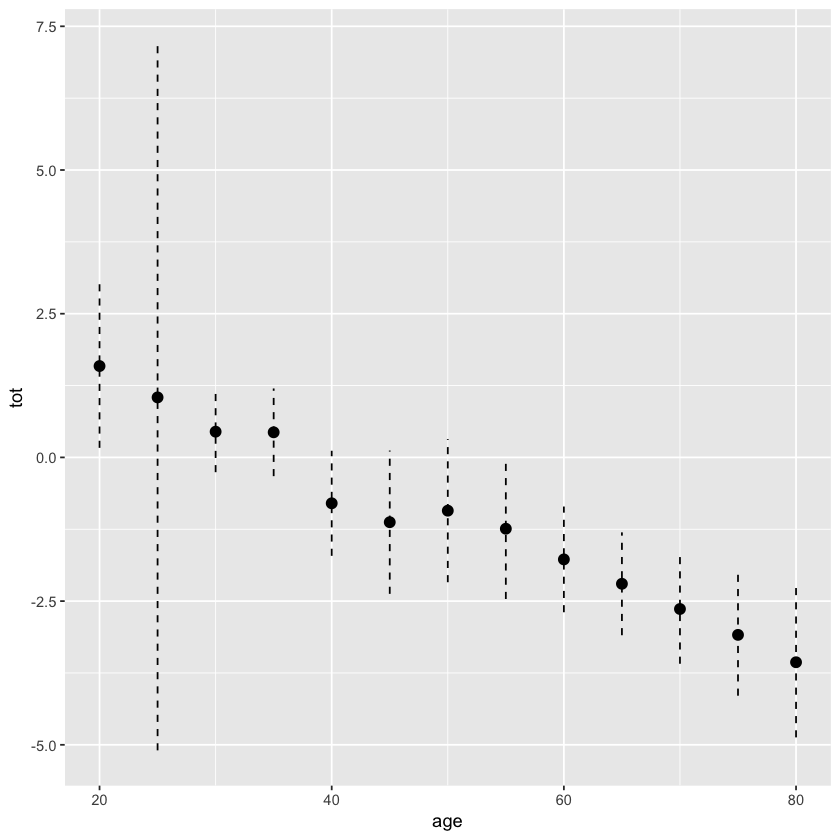

In [18]:
plot.data <- data.frame(age = pred.data$age, tot=theta.hat, se=2*se.jack)
ggplot(plot.data, aes(age, tot)) + geom_pointrange(aes(ymin=tot-se, ymax=tot+se), linetype=2) 
# 2 일때만 굉장히 크게 나옴 ! = dependence on local derivatives (weakness of Jackknife)

## 10.2 The Nonparametric Bootstrap 

### example 3. student test eigenratio

In [19]:
# nonparametric bootstrap : 추정한 f로부터 random하게 x sample을 뽑고 -> 이로부터 theta hat이 얼마나 다른지를 보겠다 
student <- read_delim("http://web.stanford.edu/~hastie/CASI_files/DATA/student_score.txt", delim=" ")

Parsed with column specification:
cols(
  mech = col_double(),
  vecs = col_double(),
  alg = col_double(),
  analy = col_double(),
  stat = col_double()
)


In [20]:
n = nrow(student) ; p = ncol(student)
eigenvalues = eigen(cor(student))$values # eigenvalue 계산 
eigenratio = eigenvalues[1] / sum(eigenvalues) # 전체 변동 중 첫번째 eigenvector가 얼만큼 설명 가능한가 
eigenratio

[1] 0.6925353

In [21]:
B = 2000 
boot.all <- NULL 
for(i in 1:B){
    sampleid <- sample(1:n, replace=TRUE) # bootstrap sample, with replacement 
    eigenvalues <- eigen(cor(student[sampleid, ]))$values 
    boot.all <- c(boot.all, eigenvalues[1]/sum(eigenvalues)) # eigenratio
}

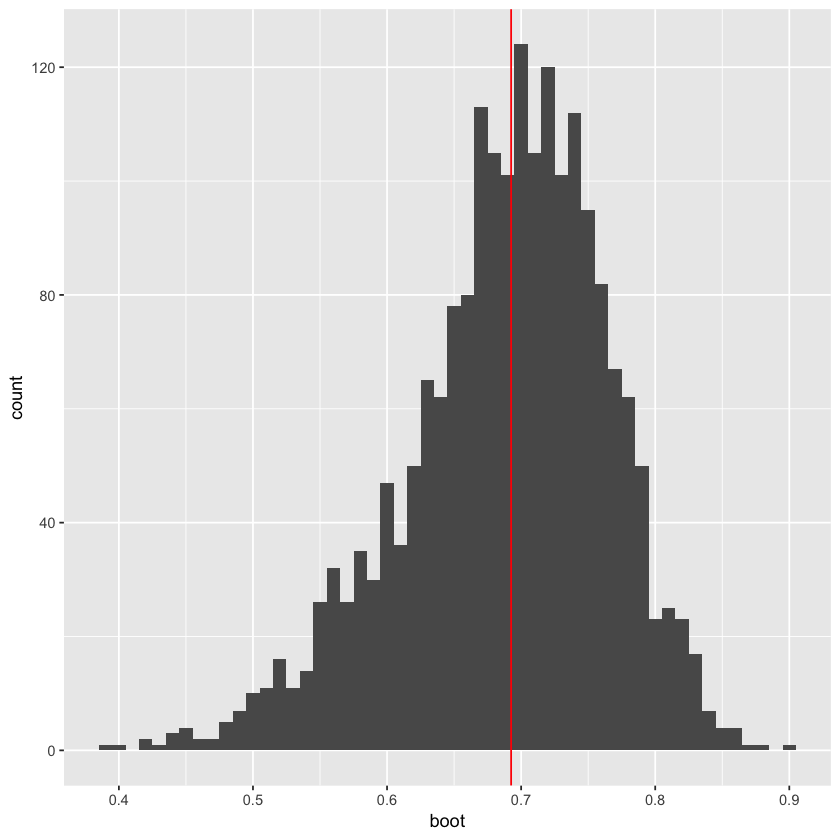

In [23]:
plot.data <- data.frame(boot = boot.all)
ggplot(plot.data, aes(boot)) + geom_histogram(binwidth = 0.01) + geom_vline(xintercept=eigenratio, col="red") # 0.693 

In [24]:
se.boot <- sd(boot.all) ; se.boot

[1] 0.07599113

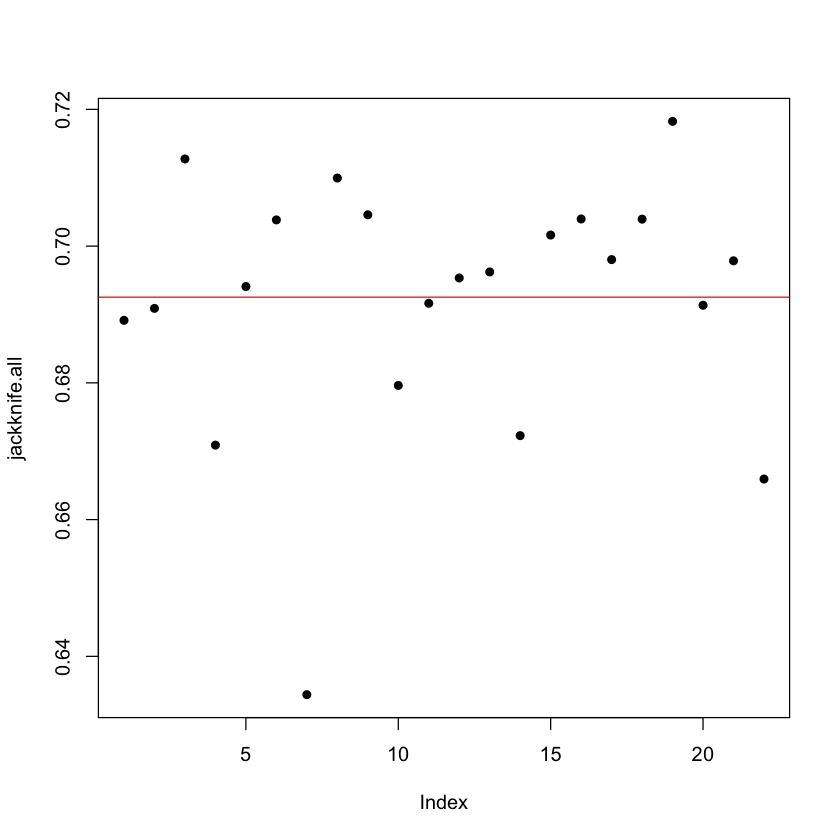

In [25]:
# 똑같은 것을 가지고 jackknife
jackknife.all <- NULL 
for(i in 1:n){
    eigenvalues = eigen(cor(student[-i, ]))$values # i번째 제외하고 eigenvalue 계산 
    jackknife.all = c(jackknife.all, eigenvalues[1] / sum(eigenvalues))
}

plot(jackknife.all, pch=16)
abline(h=eigenratio, col="red")

In [26]:
se.jack = sqrt((n-1)/n * sum((jackknife.all - mean(jackknife.all))^2)) ; se.jack # bootstrap 방법보다는 약간 크게 나옴 

[1] 0.08300211

## 10.3 Resampling Plans 

### example 4. Multisample Bootstrap - AML vs ALL (Fig 10.4) 

In [27]:
leuk <- read_csv("http://web.stanford.edu/~hastie/CASI_files/DATA/leukemia_big.csv")

Warning message:
“Duplicated column names deduplicated: 'ALL' => 'ALL_1' [2], 'ALL' => 'ALL_2' [3], 'ALL' => 'ALL_3' [4], 'ALL' => 'ALL_4' [5], 'ALL' => 'ALL_5' [6], 'ALL' => 'ALL_6' [7], 'ALL' => 'ALL_7' [8], 'ALL' => 'ALL_8' [9], 'ALL' => 'ALL_9' [10], 'ALL' => 'ALL_10' [11], 'ALL' => 'ALL_11' [12], 'ALL' => 'ALL_12' [13], 'ALL' => 'ALL_13' [14], 'ALL' => 'ALL_14' [15], 'ALL' => 'ALL_15' [16], 'ALL' => 'ALL_16' [17], 'ALL' => 'ALL_17' [18], 'ALL' => 'ALL_18' [19], 'ALL' => 'ALL_19' [20], 'AML' => 'AML_1' [22], 'AML' => 'AML_2' [23], 'AML' => 'AML_3' [24], 'AML' => 'AML_4' [25], 'AML' => 'AML_5' [26], 'AML' => 'AML_6' [27], 'AML' => 'AML_7' [28], 'AML' => 'AML_8' [29], 'AML' => 'AML_9' [30], 'AML' => 'AML_10' [31], 'AML' => 'AML_11' [32], 'AML' => 'AML_12' [33], 'AML' => 'AML_13' [34], 'ALL' => 'ALL_20' [35], 'ALL' => 'ALL_21' [36], 'ALL' => 'ALL_22' [37], 'ALL' => 'ALL_23' [38], 'ALL' => 'ALL_24' [39], 'ALL' => 'ALL_25' [40], 'ALL' => 'ALL_26' [41], 'ALL' => 'ALL_27' [42], 'ALL' => '

In [31]:
Leuk136 <- t(leuk[136, ]) # 136번 data 
group <- unlist(lapply(strsplit(rownames(Leuk136), split="_"), function(x) x[[1]][1]))

ALL = Leuk136[group=="ALL"] ; AML = Leuk136[group=="AML"]
mediff = median(AML) - median(ALL) # original estimate

In [32]:
# 각 그룹마다 따로 뽑아서 계산한다 

B = 500 
boot.all <- NULL 
for(i in 1:B){ x
    ALL.id = sample(1:length(ALL), replace=TRUE) # ALL sample 
    AML.id = sample(1:length(AML), replace=TRUE) # AML sample 
    boot.all = c(boot.all, median(AML[AML.id] - median(ALL[ALL.id]))) # bootstrap sample로부터 계산한 estimate 
} 

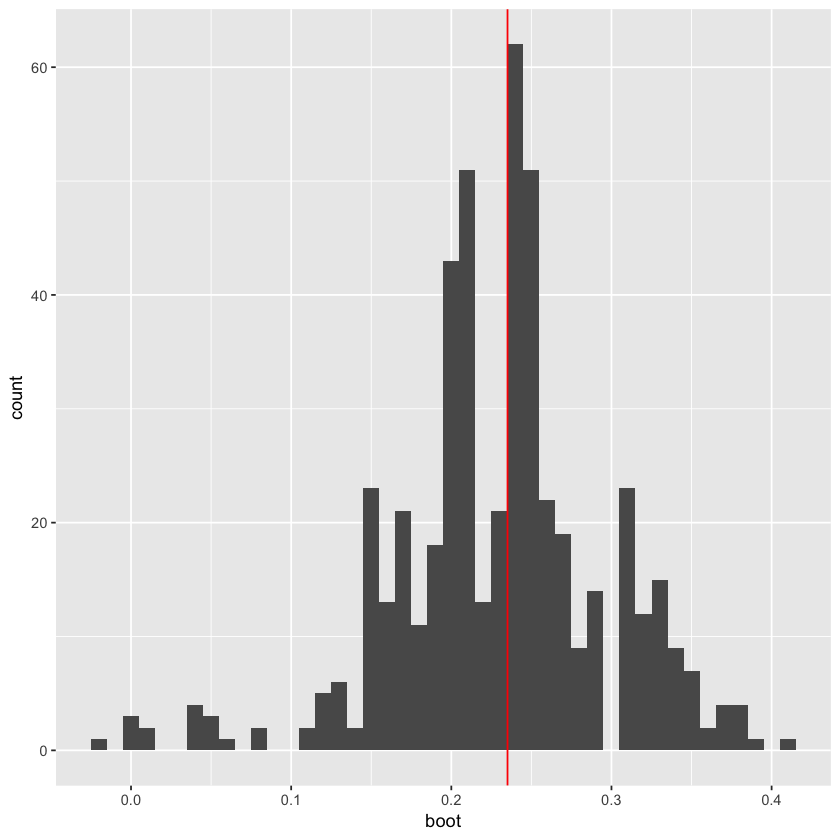

In [33]:
plot.data = data.frame(boot = boot.all)
ggplot(plot.data, aes(boot)) + geom_histogram(binwidth=0.01) + geom_vline(xintercept=mediff, col="red")

In [34]:
se.boot = sd(boot.all) ; se.boot

[1] 0.06654577

## 10.4 The Parametric Bootstrap 

### example 5. gfr data 

In [35]:
# parametric bootstrap : F(mu hat) 넣어서, 이 분포로부터 ramdom sample을 뽑아내고, theta hat* 계산 
gfr <- read_delim("http://web.stanford.edu/~hastie/CASI_files/DATA/gfr.txt", delim=" ", col_names=FALSE)

Parsed with column specification:
cols(
  X1 = col_double()
)


In [36]:
midX = seq(14.5, 107.5, by=3)
rangeX = seq(13, 109, by=3) 
levels = cut_interval(13:109, 32) # K=32 / 13, 16, 19, ..., 109 
Y = integer(length(midX)) # yk = pois(mu k)
group_index = integer(length(gfr$X1))

In [37]:
for(i in 1:length(Y)){
    Y[i] = sum(gfr$X1 > rangeX[i] & gfr$X1 <= rangeX[i+1]) # 그룹별 count
    group_index[gfr$X1 > rangeX[i] & gfr$X1 <= rangeX[i+1]] = i   
}

In [38]:
pois.data <- data.frame(y=Y, x1=midX, x2=midX^2, x3=midX^3, x4=midX^4, x5=midX^5, x6=midX^6, x7=midX^7)

In [39]:
# mu hat : 6가지 모형을 가정하고, 각가에서 ramdom sample 뽑아서 추정 
M2 <- glm(y~x1+x2, data=pois.data, family=poisson) # pois(2)
M3 <- glm(y~x1+x2+x3, data=pois.data, family=poisson) # pois(3)
M4 <- glm(y~x1+x2+x3+x4, data=pois.data, family=poisson) # pois(4)
M5 <- glm(y~x1+x2+x3+x4+x5, data=pois.data, family=poisson) # pois(5)
M6 <- glm(y~x1+x2+x3+x4+x5+x6, data=pois.data, family=poisson) # pois(6)
M7 <- glm(y~x1+x2+x3+x4+x5+x6+x7, data=pois.data, family=poisson) # pois(7)

In [40]:
# coef 곱함 
logM2 <- as.matrix(cbind(1, pois.data[, 2:3])) %*% matrix(coef(M2)) # 2차항 
logM3 <- as.matrix(cbind(1, pois.data[, 2:4])) %*% matrix(coef(M3)) # 3차항 
logM4 <- as.matrix(cbind(1, pois.data[, 2:5])) %*% matrix(coef(M4)) # 4차항 
logM5 <- as.matrix(cbind(1, pois.data[, 2:6])) %*% matrix(coef(M5)) # 5차항 
logM6 <- as.matrix(cbind(1, pois.data[, 2:7])) %*% matrix(coef(M6)) # 6차항 
logM7 <- as.matrix(cbind(1, pois.data[, 2:8])) %*% matrix(coef(M7)) # 7차항 

In [41]:
plot.data <- data.frame(x = midX, 
                        df2 = exp(predict(M2)), # 각각 prediction 한 것 
                        df3 = exp(predict(M3)), 
                        df4 = exp(predict(M4)), 
                        df5 = exp(predict(M5)), 
                        df6 = exp(predict(M6)),
                        df7 = exp(predict(M7)))

In [42]:
plot.data = plot.data %>% gather(key = "df", value="value", -x)

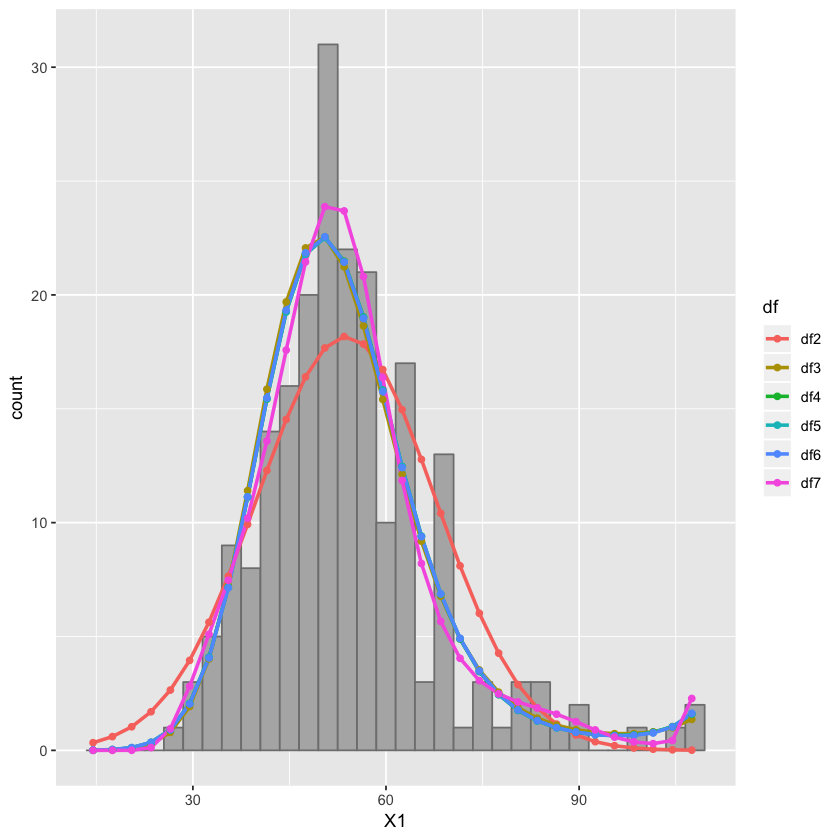

In [43]:
ggplot() + 
    geom_histogram(data=gfr, aes(X1), fill="grey70", color="grey50", binwidth=3) + 
    geom_line(data = plot.data, aes(x, value, color=df), size=1) + 
    geom_point(data = plot.data, aes(x, value, color=df))

In [45]:
# 각각의 모형(poisson)의 mu k에서 bootstrap sample(ramdom number) 뽑아냄 
B = 200
boot.2 <- NULL 
boot.3 <- NULL 
boot.4 <- NULL 
boot.5 <- NULL 
boot.6 <- NULL 
boot.7 <- NULL 
boot.non <- NULL

In [46]:
for(i in 1:B){
    
    # order 2 
    Y = rpois(32, lambda=exp(logM2)) 
    boot.2 = rbind(boot.2, Y[1:9*3])
    
    # order 3
    Y = rpois(32, lambda=exp(logM3))
    boot.3 = rbind(boot.3, Y[1:9*3])
    
    # order 4
    Y = rpois(32, lambda=exp(logM4))
    boot.4 = rbind(boot.4, Y[1:9*3])
    
    # order 5
    Y = rpois(32, lambda=exp(logM5))
    boot.5 = rbind(boot.5, Y[1:9*3])
    
    # order 6
    Y = rpois(32, lambda=exp(logM5))
    boot.6 = rbind(boot.6, Y[1:9*3])
    
    # order 7
    Y = rpois(32, lambda=exp(logM5))
    boot.7 = rbind(boot.7, Y[1:9*3])
    
    # nonparametric
    Y.id = sample(1:n, replace=TRUE) # data sampling 
    boot.Y = gfr$X1[Y.id] # sampling한 id 뽑아내서, table 만들기 
    Y = integer(length(midX))
    for(i in 1:length(Y))
        Y[i] = sum(boot.Y > rangeX[i] & boot.Y <= rangeX[i+1])
    boot.non = rbind(boot.non, Y[1:9*3])
    
}

In [47]:
tot <- cbind(midX[1:9*3], 
             round(apply(boot.2, 2, sd), 2),  
             round(apply(boot.3, 2, sd), 2), 
             round(apply(boot.4, 2, sd), 2), 
             round(apply(boot.5, 2, sd), 2), 
             round(apply(boot.6, 2, sd), 2), 
             round(apply(boot.7, 2, sd), 2), 
             round(apply(boot.non, 2, sd), 2))

colnames(tot) = c("gfr", paste0("df", 2:7), "nonparam") ; tot 

gfr,df2,df3,df4,df5,df6,df7,nonparam
20.5,1.12,0.21,0.37,0.29,0.26,0.32,0.00
29.5,1.98,1.24,1.48,1.27,1.43,1.40,0.00
38.5,3.35,3.07,3.46,3.17,3.34,3.32,0.00
47.5,4.15,4.87,4.62,4.38,4.52,4.80,0.00
56.5,3.82,4.01,4.41,3.94,4.51,4.38,0.00
65.5,3.69,2.92,3.09,2.94,3.23,2.97,1.30
74.5,2.37,1.86,1.80,1.89,1.89,1.77,0.91
83.5,1.38,1.19,1.12,1.22,1.20,1.04,1.38
92.5,0.64,0.82,0.93,0.86,0.85,0.84,0.00


### example 6. student score eigenratio calculation 

In [48]:
student <- read_delim("http://web.stanford.edu/~hastie/CASI_files/DATA/student_score.txt", delim=" ")

Parsed with column specification:
cols(
  mech = col_double(),
  vecs = col_double(),
  alg = col_double(),
  analy = col_double(),
  stat = col_double()
)


In [49]:
n = nrow(student) ; p = ncol(student)
eigenvalues = eigen(cor(student))$values # eigenvalue 계산 
eigenratio = eigenvalues[1] / sum(eigenvalues) # 전체 변동 중 첫번째 eigenvector가 얼만큼 설명 가능한가 
eigenratio

[1] 0.6925353

In [50]:
meanS = colMeans(student) ; varS = var(student)
cholS = chol(varS) # Cholesky decomposition : A = LL' -> LZ+Mu, 5개의 score가 Multivariate Normal 따른다고 가정 

In [51]:
B = 2000 
boot.all <- NULL 
for(i in 1:B){
    bootS = matrix(rnorm(n*p), ncol=5) %*% cholS + matrix(rep(1,n)) %*% t(matrix(meanS))
    eigenvalues = eigen(cor(bootS))$values 
    boot.all = c(boot.all, eigenvalues[1]/sum(eigenvalues))
}

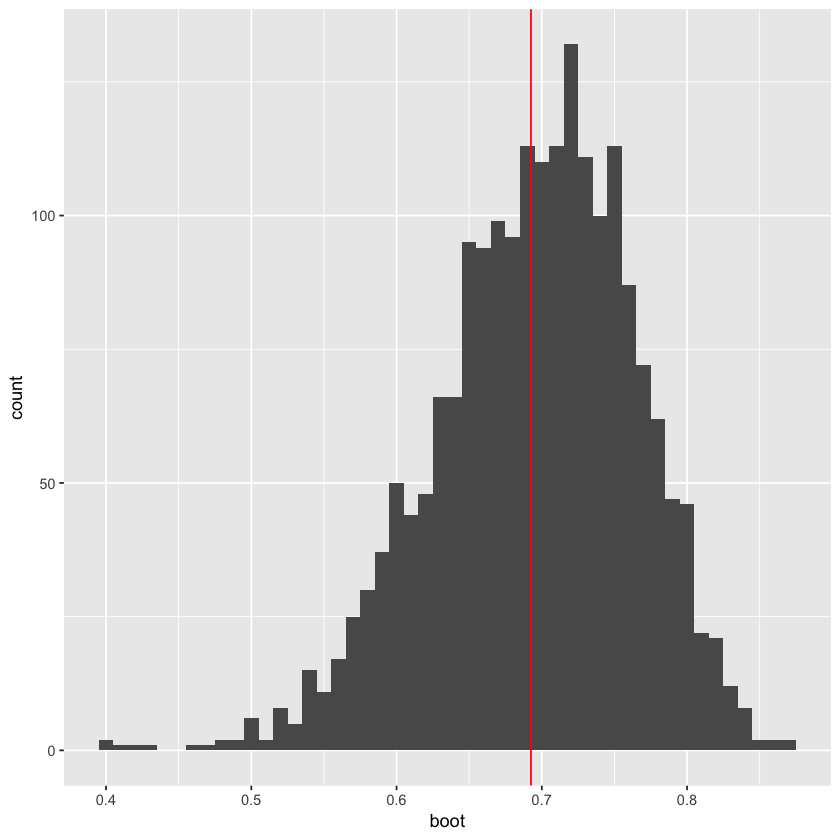

In [52]:
plot.data = data.frame(boot=boot.all)
ggplot(plot.data, aes(boot)) + 
    geom_histogram(binwidth=0.01) + 
    geom_vline(xintercept=eigenratio, col="red") # true

In [53]:
se.boot = sd(boot.all) ; se.boot # 비슷한 값 나온다 

[1] 0.06884304